In [98]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import ticker

## Compute Responsiveness Data

In [99]:
# Prepare paths
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
modes_dir = os.path.join(projectPath, 'sumoenv/scenarios/normal')

records = []
# Traverse each mode (sumo, social_groups, multi_agent)
for mode in os.listdir(modes_dir):
    mode_path = os.path.join(modes_dir, mode)
    if not os.path.isdir(mode_path):
        continue
    # Traverse each folder inside the mode
    for date in os.listdir(mode_path):
        date_path = os.path.join(mode_path, date)
        if not os.path.isdir(date_path):
            continue
        summary_path = os.path.join(date_path, 'simulation_summary.csv')
        if os.path.exists(summary_path):
            df = pd.read_csv(summary_path)
            if not df.empty:
                first_row = df.iloc[0]
                elapsed_sec = first_row['total_elapsed_seconds']
                sumo_sec = first_row['sumo_time']
                agents_sec = first_row['agents_time'] if mode.startswith(('multi_agent', 'social_groups')) else 0
                records.append({
                    'mode': mode,
                    'date': date,
                    'elapsed_seconds': elapsed_sec,
                    'elapsed_minutes': round(elapsed_sec / 60, 2),
                    'sumo_time': sumo_sec,
                    'sumo_minutes': round(sumo_sec / 60, 2),
                    'agents_time': agents_sec,
                    'agents_minutes': round(agents_sec / 60, 2),
                    'sumo_perc_time': round(sumo_sec / elapsed_sec, 2),
                    'agents_perc_time': round(agents_sec / elapsed_sec, 2) if agents_sec > 0 else 0,
                })
# Save results to CSV
summary_df = pd.DataFrame(records)
output_file = os.path.join(projectPath, 'experiments/results/responsiveness_normal.csv')
summary_df = summary_df.sort_values(by=['mode', 'date'])
summary_df.to_csv(output_file, index=False)

print(f"Responsiveness summary saved to: {output_file}")


Responsiveness summary saved to: /Users/beyzaeken/Desktop/sfdigitalmirror/experiments/results/responsiveness_normal.csv


## Compute Avg across Modes

In [100]:
df = pd.read_csv(os.path.join(projectPath, 'experiments/results/responsiveness_normal.csv'))
# Columns to average
avg_cols = ['elapsed_seconds', 'elapsed_minutes', 'sumo_time', 'sumo_minutes', 'agents_time', 'agents_minutes', 'sumo_perc_time', 'agents_perc_time']
multi_agent_modes = ['multi_agent', 'multi_agent_1']
social_group_modes = ['social_groups_1', 'social_groups_2']
# Compute averages per date_key for each group
multi_avg = (
    df[df['mode'].isin(multi_agent_modes)]
    .groupby('date')[avg_cols]
    .mean()
    .round(2)
    .reset_index()
)
multi_avg['mode'] = 'multi_agent_avg'
social_avg = (
    df[df['mode'].isin(social_group_modes)]
    .groupby('date')[avg_cols]
    .mean()
    .round(2)
    .reset_index()
)
social_avg['mode'] = 'social_groups_avg'

# Reorder columns
multi_avg = multi_avg[['mode', 'date', *avg_cols]]
social_avg = social_avg[['mode', 'date', *avg_cols]]

# Append to original dataframe and save
df_result = pd.concat([df, multi_avg, social_avg], ignore_index=True)
df_result.to_csv(os.path.join(projectPath, 'experiments/results/responsiveness_normal.csv'), index=False)

## Plot Responsiveness Data

In [101]:
# Prepare paths
projectPath = os.path.abspath(os.path.join(os.getcwd(), '..'))
df_results = pd.read_csv(os.path.join(projectPath, 'experiments/results/responsiveness_normal.csv'))
df_results = df_results[df_results['mode'].isin(['sumo', 'social_groups_avg', 'multi_agent_avg'])]

# Extract start, end and duration hour from the 'date' column
df_results['start_hour'] = df_results['date'].str.extract(r'^(\d{6})(\d{2})_')[1].astype(int)
df_results['end_hour'] = df_results['date'].str.extract(r'_(\d{6})(\d{2})$')[1].astype(int)
df_results['duration_h'] = df_results['end_hour'] - df_results['start_hour']

# Add day/night label based on starting hour
df_results['time_of_day'] = df_results['start_hour'].apply(lambda h: 'day' if h == 8 else 'night')

# Columns to average
value_columns = [
    'elapsed_seconds', 'elapsed_minutes', 'sumo_time', 'sumo_minutes',
    'agents_time', 'agents_minutes', 'sumo_perc_time', 'agents_perc_time'
]

# Assign averages to separate variables
time_sumo_1h_avg_d = df_results[(df_results['mode'] == 'sumo') & (df_results['duration_h'] == 1) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()
time_sumo_3h_avg_d = df_results[(df_results['mode'] == 'sumo') & (df_results['duration_h'] == 3) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()
time_sumo_1h_avg_n = df_results[(df_results['mode'] == 'sumo') & (df_results['duration_h'] == 1) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()
time_sumo_3h_avg_n = df_results[(df_results['mode'] == 'sumo') & (df_results['duration_h'] == 3) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()
time_ma_1h_avg_d = df_results[(df_results['mode'] == 'multi_agent_avg') & (df_results['duration_h'] == 1) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()
time_ma_3h_avg_d = df_results[(df_results['mode'] == 'multi_agent_avg') & (df_results['duration_h'] == 3) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()
time_ma_6h_avg_d = df_results[(df_results['mode'] == 'multi_agent_avg') & (df_results['duration_h'] == 6) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()
time_ma_12h_avg_d = df_results[(df_results['mode'] == 'multi_agent_avg') & (df_results['duration_h'] == 12) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()
time_ma_1h_avg_n = df_results[(df_results['mode'] == 'multi_agent_avg') & (df_results['duration_h'] == 1) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()
time_ma_3h_avg_n = df_results[(df_results['mode'] == 'multi_agent_avg') & (df_results['duration_h'] == 3) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()
time_ma_6h_avg_n = df_results[(df_results['mode'] == 'multi_agent_avg') & (df_results['duration_h'] == 6) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()
time_ma_12h_avg_n = df_results[(df_results['mode'] == 'multi_agent_avg') & (df_results['duration_h'] == 12) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()
time_sg_1h_avg_d = df_results[(df_results['mode'] == 'social_groups_avg') & (df_results['duration_h'] == 1) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()
time_sg_3h_avg_d = df_results[(df_results['mode'] == 'social_groups_avg') & (df_results['duration_h'] == 3) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()
time_sg_6h_avg_d = df_results[(df_results['mode'] == 'social_groups_avg') & (df_results['duration_h'] == 6) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()
time_sg_12h_avg_d = df_results[(df_results['mode'] == 'social_groups_avg') & (df_results['duration_h'] == 12) & (df_results['time_of_day'] == 'day')]['elapsed_seconds'].mean()
time_sg_1h_avg_n = df_results[(df_results['mode'] == 'social_groups_avg') & (df_results['duration_h'] == 1) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()
time_sg_3h_avg_n = df_results[(df_results['mode'] == 'social_groups_avg') & (df_results['duration_h'] == 3) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()
time_sg_6h_avg_n = df_results[(df_results['mode'] == 'social_groups_avg') & (df_results['duration_h'] == 6) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()
time_sg_12h_avg_n = df_results[(df_results['mode'] == 'social_groups_avg') & (df_results['duration_h'] == 12) & (df_results['time_of_day'] == 'night')]['elapsed_seconds'].mean()

In [102]:
sumo_avg_d = [time_sumo_1h_avg_d, time_sumo_3h_avg_d, np.nan, np.nan]
ma_avg_d = [time_ma_1h_avg_d, time_ma_3h_avg_d, time_ma_6h_avg_d, time_ma_12h_avg_d]
sg_avg_d = [time_sg_1h_avg_d, time_sg_3h_avg_d, time_sg_6h_avg_d, time_sg_12h_avg_d]
sumo_avg_n = [time_sumo_1h_avg_n, time_sumo_3h_avg_n, np.nan, np.nan]
ma_avg_n = [time_ma_1h_avg_n, time_ma_3h_avg_n, time_ma_6h_avg_n, time_ma_12h_avg_n]
sg_avg_n = [time_sg_1h_avg_n, time_sg_3h_avg_n, time_sg_6h_avg_n, time_sg_12h_avg_n]
# Estimate SUMO day and night for 6 and 12 hours using power law fitting
x_hours_known = np.array([1, 3])
y_sumo_day_known = np.array([time_sumo_1h_avg_d, time_sumo_3h_avg_d])
y_sumo_night_known = np.array([time_sumo_1h_avg_n, time_sumo_3h_avg_n])

def power_law(x, a, b):
    return a * x**b

# Fit SUMO day
popt_day, _ = curve_fit(power_law, x_hours_known, y_sumo_day_known)
estimated_day_6h = power_law(6, *popt_day)
estimated_day_12h = power_law(12, *popt_day)

# Fit SUMO night
popt_night, _ = curve_fit(power_law, x_hours_known, y_sumo_night_known)
estimated_night_6h = power_law(6, *popt_night)
estimated_night_12h = power_law(12, *popt_night)

# Update sumo_avg arrays
sumo_avg_d = [time_sumo_1h_avg_d, time_sumo_3h_avg_d, estimated_day_6h, estimated_day_12h]
sumo_avg_n = [time_sumo_1h_avg_n, time_sumo_3h_avg_n, estimated_night_6h, estimated_night_12h]

/var/folders/03/ywz8jzld3gs1b0zsd9kydy940000gq/T/ipykernel_54471/249602213.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_day, _ = curve_fit(power_law, x_hours_known, y_sumo_day_known)
/var/folders/03/ywz8jzld3gs1b0zsd9kydy940000gq/T/ipykernel_54471/249602213.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_night, _ = curve_fit(power_law, x_hours_known, y_sumo_night_known)


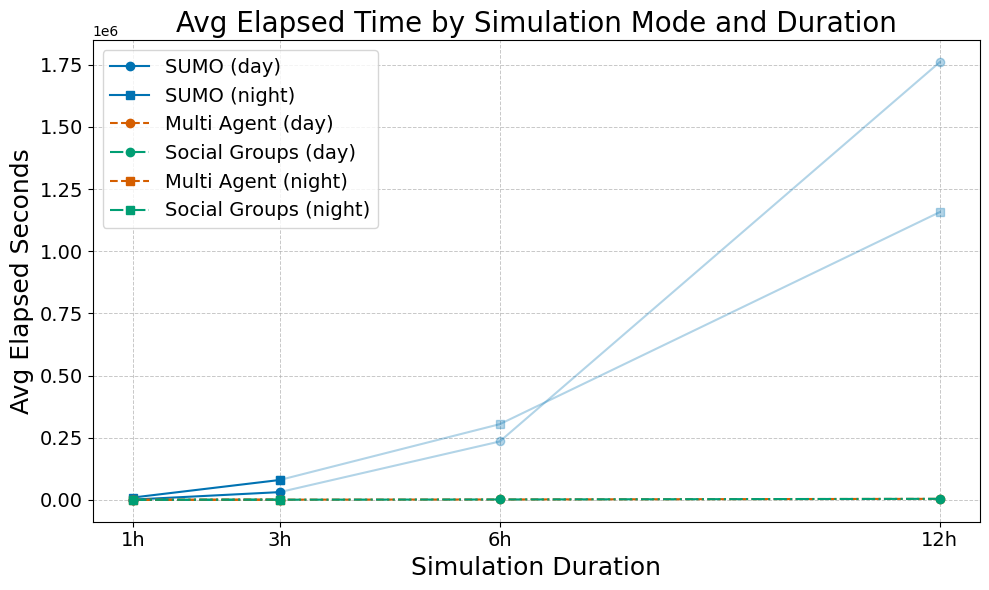

In [ ]:
# Colors and styles
colors= ['#0072B2', '#D55E00', '#009E73']
linestyles = ['-', '--', '-.']

x_hours = np.array([1, 3, 6, 12])
x_labels = ['1h', '3h', '6h', '12h']

plt.figure(figsize=(10, 6))

# Plot SUMO
plt.plot(x_hours[:2], sumo_avg_d[:2], marker='o', color=colors[0], label='SUMO (day)')
plt.plot(x_hours[1:], sumo_avg_d[1:], marker='o', color=colors[0], alpha = 0.3)
plt.plot(x_hours[:2], sumo_avg_n[:2], marker='s', color=colors[0], linestyle='-', label='SUMO (night)')
plt.plot(x_hours[1:], sumo_avg_n[1:], marker='s', color=colors[0], alpha = 0.3)

# Plot other modes
plt.plot(x_hours, ma_avg_d, marker='o', label='Multi Agent (day)', color=colors[1], linestyle=linestyles[1])
plt.plot(x_hours, sg_avg_d, marker='o', label='Social Groups (day)', color=colors[2], linestyle=linestyles[2])
plt.plot(x_hours, ma_avg_n, marker='s', label='Multi Agent (night)', color=colors[1], linestyle=linestyles[1])
plt.plot(x_hours, sg_avg_n, marker='s', label='Social Groups (night)', color=colors[2], linestyle=linestyles[2])

# Set log scale and formatting
#plt.yscale('log')
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0f}'.format(y) if y > 0 else '0'))

# Label and style
plt.xticks(x_hours, x_labels, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Simulation Duration', fontsize=18)
plt.ylabel('Avg Elapsed Seconds', fontsize=18)
plt.title('Avg Elapsed Time by Simulation Mode and Duration', fontsize=20)
plt.legend(fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.savefig("results/responsiveness.png", dpi=300, bbox_inches='tight')
plt.show()